In [1]:
import torch
import torch.autograd
import numpy as np
import matplotlib.pyplot as plt
import numml.sparse as sp
import numml.krylov as kry

In [2]:
# Create our favorite poisson operator

N = 8
A = sp.eye(N)*2. - sp.eye(N, k=1) - sp.eye(N, k=-1)
print(A.to_dense())

tensor([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])


In [3]:
# Create our starting initial guess to A^{-1}, which we'll be lazy and initialize to A itself

Ainv = A.copy() + sp.eye(N, k=2) + sp.eye(N, k=-2)
Ainv_start = Ainv.copy()
Ainv.requires_grad = True
Ainv.to_dense()

tensor([[ 2., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  2., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 1., -1.,  2., -1.,  1.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  2., -1.,  1.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  2., -1.,  1.,  0.],
        [ 0.,  0.,  0.,  1., -1.,  2., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  1., -1.,  2., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -1.,  2.]], grad_fn=<CopySlices>)

In [4]:
(A@Ainv).to_dense()

tensor([[ 5., -4.,  3., -1.,  0.,  0.,  0.,  0.],
        [-5.,  6., -5.,  3., -1.,  0.,  0.,  0.],
        [ 3., -5.,  6., -5.,  3., -1.,  0.,  0.],
        [-1.,  3., -5.,  6., -5.,  3., -1.,  0.],
        [ 0., -1.,  3., -5.,  6., -5.,  3., -1.],
        [ 0.,  0., -1.,  3., -5.,  6., -5.,  3.],
        [ 0.,  0.,  0., -1.,  3., -5.,  6., -5.],
        [ 0.,  0.,  0.,  0., -1.,  3., -4.,  5.]], grad_fn=<CopySlices>)

In [5]:
# Confirm our matmat product even works at all

torch.allclose((A@Ainv).to_dense(), A.to_dense() @ Ainv.to_dense())

True

In [6]:
# Optimize || A @ Ainv - I ||_F^2 + || Ainv @ A - I ||_F^2

optimizer = torch.optim.Adam([Ainv.data], lr=0.1)
lh = []
epochs = 300

for i in range(epochs):
    optimizer.zero_grad()
    
    loss_AAinv = (((A @ Ainv) - sp.eye(N)) ** 2.).sum()
    loss_AinvA = (((Ainv @ A) - sp.eye(N)) ** 2.).sum()
    loss = loss_AAinv + loss_AinvA
    loss.backward()
    
    optimizer.step()
    
    lh.append(loss.item())
    if i % 10 == 0 or i == epochs - 1:
        print(i, loss.item())

0 1264.0
10 65.00367736816406
20 65.44514465332031
30 22.18129539489746
40 6.93930196762085
50 5.281045913696289
60 2.6295430660247803
70 2.1336565017700195
80 1.9847989082336426
90 1.7738406658172607
100 1.7615363597869873
110 1.7036938667297363
120 1.6730196475982666
130 1.6465144157409668
140 1.6215102672576904
150 1.6002333164215088
160 1.5814106464385986
170 1.5648002624511719
180 1.5503299236297607
190 1.537787914276123
200 1.5269824266433716
210 1.517737865447998
220 1.5098819732666016
230 1.503248691558838
240 1.497684121131897
250 1.4930455684661865
260 1.489202618598938
270 1.4860389232635498
280 1.483449935913086
290 1.4813441038131714
299 1.4797954559326172


Text(0.5, 1.0, 'Loss history')

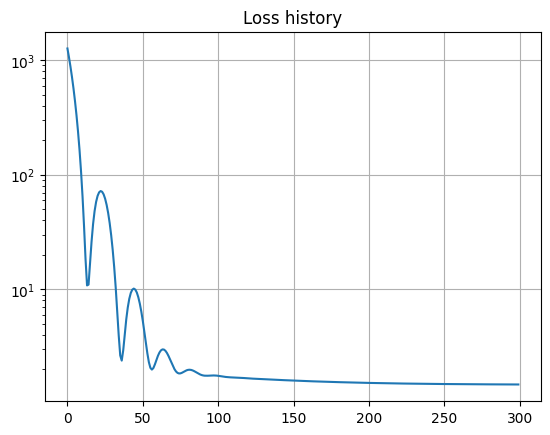

In [7]:
plt.semilogy(lh)
plt.grid()
plt.title('Loss history')

In [8]:
(A@Ainv).to_dense()

tensor([[ 0.9801, -0.0548, -0.1069, -0.1507,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0380,  0.9068, -0.1308, -0.1289, -0.1400,  0.0000,  0.0000,  0.0000],
        [-0.0670, -0.1256,  0.8551, -0.1414, -0.1415, -0.1400,  0.0000,  0.0000],
        [-0.1758, -0.1571, -0.1513,  0.8509, -0.1484, -0.1504, -0.1507,  0.0000],
        [ 0.0000, -0.1507, -0.1504, -0.1484,  0.8509, -0.1513, -0.1571, -0.1758],
        [ 0.0000,  0.0000, -0.1400, -0.1415, -0.1414,  0.8551, -0.1256, -0.0670],
        [ 0.0000,  0.0000,  0.0000, -0.1400, -0.1289, -0.1308,  0.9068, -0.0380],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.1507, -0.1069, -0.0548,  0.9801]],
       grad_fn=<CopySlices>)

In [9]:
Ainv.to_dense()

tensor([[0.6993, 0.4186, 0.1758, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4186, 0.8919, 0.4585, 0.1507, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1758, 0.4585, 0.8719, 0.4303, 0.1400, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1507, 0.4303, 0.8513, 0.4214, 0.1400, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1400, 0.4214, 0.8513, 0.4303, 0.1507, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1400, 0.4303, 0.8719, 0.4585, 0.1758],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1507, 0.4585, 0.8919, 0.4186],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1758, 0.4186, 0.6993]],
       grad_fn=<CopySlices>)